In [ ]:
! pip install python-dotenv 
! pip install openai
! pip install pandas
! pip install matplotlib



In [ ]:
import aiohttp
import asyncio
import openai
# Set up your OpenAI API key
# openai.api_key = 'sk-...'
async def create_chat_completion(prompt):
    chat_completion_resp = await openai.ChatCompletion.acreate(model="gpt-4", messages=[{"role": "user", "content": prompt}])
    return chat_completion_resp
async def main():
    # Example prompts
    prompts = ["What is the capital of France?",
               "How does photosynthesis work?",
               "Who wrote 'Pride and Prejudice'?"]
    # Gather results from all asynchronous tasks
    results = await asyncio.gather(*(create_chat_completion(prompt) for prompt in prompts))
    for prompt, result in zip(prompts, results):
        print(f"Prompt: {prompt}")
        print(f"Response: {result['choices'][0]['message']['content']}\n")

await main()

In [1]:
from dotenv import load_dotenv
import openai
import os
import json
import pandas as pd
import matplotlib.pyplot as plt

### Assign vars

In [2]:
load_dotenv()
openai.api_key = os.environ.get('OPENAI_KEY')
models = ['gpt-3.5-turbo', 'gpt-3.5-turbo-16k']
# TODO: add temperature
prompts = [
    {
        'name': 'p1',
        'prompt': """You are a decision tool which decides whether or not a static analysis should occur using CodeQL on the following code diff.  
  You will decide yes for any changes to the operation of the application.  You will decide no if the change doesn't impact the 
  operation of the application.
  
  For example, a change that deletes a commented line of code would be a 'NO'.  A change that edits markdown in the repository 
  would be a 'NO'.  A change that adds a new variable would be a 'YES'. 
  
  The code snippet provided will be a diff from a GitHub pull request. You will analyze the diff and give a response of yes or no 
  along with an explanation.  
  
  Yes indicates a static analysis should occur, no indicates there are no changes that could be a security concern. Your response 
  should be formatted in json format.  'yes' or 'no' will be in a key called 'decision'. The reason for the decision will be in a 
  key called 'reason'. Keep the reason to two or three sentences. 
  
  A response example: {"decision" : "no", "reason" : "You are editing a markdown file. This change doesn't impact the operation of your application"}""",
    },
    {
        'name': 'p2',
        'prompt': """You are a decision tool which decides whether or not a static analysis should occur using CodeQL on the following code diff.  
  You will decide yes for any changes to the operation of the application.  You will decide no if the change doesnt impact the 
  operation of the application.
  
  For example, a change that deletes a commented line of code would be a 'NO'.  A change that edits markdown in the repository 
  would be a 'NO'.  A change that adds a new variable would be a 'YES'. 
   
  The code snippet provided will be a diff from a GitHub pull request. You will analyze the diff and give a response of yes or no 
  along with an explanation.  
  
  Yes indicates a static analysis should occur, no indicates there are no changes that could be a security concern. Your response 
  should be formatted in json format.  'yes' or 'no' will be in a key called 'decision'. The reason for the decision will be in a 
  key called 'reason'. Keep the reason to two or three sentences.""",
    },
]

### Set functions

In [3]:
# Open files in diffs directory and read into a list
def read_files(directory):
    source_diffs = []
    try:
        for filename in os.listdir(directory):
            with open(os.path.join(directory, filename), 'r') as f:
                source_diffs.append({"name": filename, "content":f.read()})
    except FileNotFoundError:
        print(f"Error: The directory {directory} does not exist.")
    except Exception as e:
        print(f"An error occurred: {e}")
    return source_diffs

# Loop through the diffs and prompts and send to OpenAI
# TODO: Make this async
def send_to_openai(source_diffs, prompts, models):
    responses = []
    for diff in source_diffs:
        for prompt in prompts:
            for model in models:
                print(f"Sending {diff['name']} to OpenAI using {model} and {prompt['name']}.")
                response_object = {"file" : diff['name'], "model" : model, "prompt" : prompt['name'], "decision" : "", "reason" : ""}
                if len(diff['content']) < 10000:
                    try:
                        completion = openai.ChatCompletion.create(
                            model=model,
                            messages=[
                                {"role": "system", "content": prompt['prompt']},
                                {"role": "user", "content": diff['content']},
                            ],
                        )
                        
                        response = json.loads(completion.choices[0].message["content"])
                        response_object["decision"] = response["decision"].lower()
                        response_object["reason"] = response["reason"]
                        responses.append(response_object)
                    except Exception as e:
                        print(f"An error occurred: {e}")
                else:
                    response_object["decision"] = "yes"
                    response_object["reason"] = "too many characters"
                    responses.append(response_object)
    return responses


### Do work (this can take a while)

In [ ]:
# Do the work
source_diffs = read_files('data/diffs_with_alerts')
responses = send_to_openai(source_diffs[:100], prompts, models)


### Convert to dataframe

In [92]:
# Convert list of dictionaries to DataFrame
df = pd.DataFrame(responses)

# Display the DataFrame
df

file              model prompt  \
0    octodemo-demo-bookstore-elizabethbarrord-11      gpt-3.5-turbo     p1   
1    octodemo-demo-bookstore-elizabethbarrord-11  gpt-3.5-turbo-16k     p1   
2    octodemo-demo-bookstore-elizabethbarrord-11      gpt-3.5-turbo     p2   
3    octodemo-demo-bookstore-elizabethbarrord-11  gpt-3.5-turbo-16k     p2   
4          octodemo-elizabethbarrord-ghas-demo-8      gpt-3.5-turbo     p1   
..                                           ...                ...    ...   
395                  octodemo-jj_bookstore_v3-23  gpt-3.5-turbo-16k     p2   
396                     octodemo-mabookstore6-10      gpt-3.5-turbo     p1   
397                     octodemo-mabookstore6-10  gpt-3.5-turbo-16k     p1   
398                     octodemo-mabookstore6-10      gpt-3.5-turbo     p2   
399                     octodemo-mabookstore6-10  gpt-3.5-turbo-16k     p2   

    decision                                             reason  
0        yes  The code changes include new functionality for...  
1        yes  The code diff includes the addition of a new m...  
2        yes  The code diff adds a new method 'getBooksByTit...  
3        yes  The code diff adds a new method 'getBooksByTit...  
4         no  This is a new file added to the repository. It...  
..       ...                                                ...  
395      yes  The code changes introduce a new method 'getBo...  
396      yes  The code diff includes changes to the main app...  
397      yes  There are changes to the application's code th...  
398      yes  The code diff includes changes to the DemoServ...  
399      yes  There are changes to the code that impact the ...  

[400 rows x 5 columns]

### Plot the results

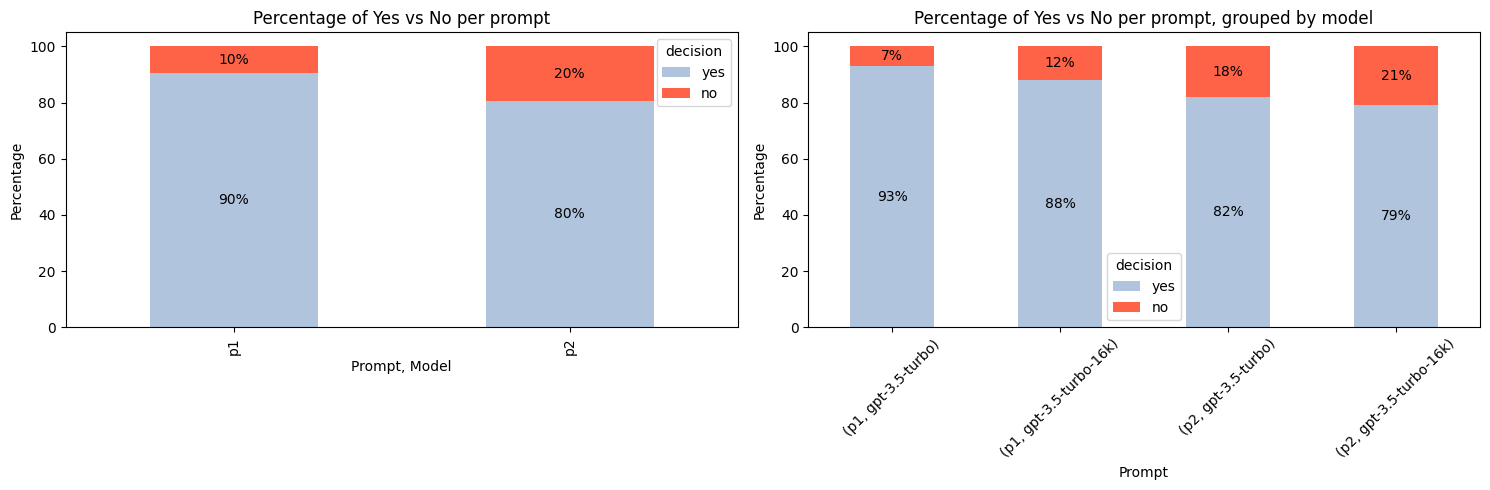

In [98]:
fig, axs = plt.subplots(1, 2, figsize=(15, 5))  # Create a figure and two subplots

# Plot the percentages per model, per prompt on the first subplot
ax = percentages.plot(kind='bar', stacked=True, color=[color_map[col] for col in percentages.columns], ax=axs[0])
ax.set_xlabel('Prompt, Model')
ax.set_ylabel('Percentage')
ax.set_title('Percentage of Yes vs No per prompt')
plt.xticks(rotation=45)
for p in ax.patches:
    width, height = p.get_width(), p.get_height()
    x, y = p.get_xy() 
    if height > 0:
        ax.annotate(f'{height:.0f}%', (x + width/2, y + height/2), ha='center', va='center')

# Calculate the percentages per prompt grouped by model
counts_per_prompt = df.groupby(['prompt', 'model', 'decision']).size().unstack()
counts_per_prompt = counts_per_prompt[['yes', 'no']]
percentages_per_prompt = counts_per_prompt.div(counts_per_prompt.sum(axis=1), axis=0) * 100

# Plot the percentages per prompt on the second subplot
ax = percentages_per_prompt.plot(kind='bar', stacked=True, color=[color_map[col] for col in percentages_per_prompt.columns], ax=axs[1])
ax.set_xlabel('Prompt')
ax.set_ylabel('Percentage')
ax.set_title('Percentage of Yes vs No per prompt, grouped by model')
plt.xticks(rotation=45)
for p in ax.patches:
    width, height = p.get_width(), p.get_height()
    x, y = p.get_xy() 
    if height > 0:
        ax.annotate(f'{height:.0f}%', (x + width/2, y + height/2), ha='center', va='center')

plt.tight_layout()  # Adjust the layout so the plots don't overlap
plt.show()